In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas
import math

# make this point to the file with the clean tweets
DATAFILE = "data_clean_stemmed_withoutRT.csv"
# make this point to the file with the text tweets
TWEETSFILE = "data_original_notStemmed_withoutRT.csv"

In [2]:
# import the tweets
text_tweets = pandas.read_csv(TWEETSFILE, index_col=0)
# read the csv
data = pandas.read_csv(DATAFILE, index_col=0)
# get all the tweets
# as of now, they are still strings, the string representation of the list
tweets = []
for tweet in data["text"]:
    tweets.append(eval(tweet))
    
# find all unique words and count them
uniqueWords = {}
total_words = 0
for tweet in tweets:
    for word in tweet:
        total_words += 1
        if word in uniqueWords.keys():
            uniqueWords[word] += 1
        else:
            uniqueWords[word] = 1
print(f"We have {total_words} words, of which {len(uniqueWords.keys())} are unique")
words_tuples = [(word, uniqueWords[word]) for word in uniqueWords.keys()]
words_tuples.sort(reverse=True, key=lambda t: t[1])
print(words_tuples[0:10])

We have 53305 words, of which 4820 are unique
[('great', 832), ('peopl', 433), ('countri', 410), ('border', 351), ('democrat', 342), ('get', 308), ('state', 303), ('presid', 299), ('u', 292), ('trump', 287)]


In [3]:
def explore_clusters(cluster_list, callback=None):
    """Explores the list of clusters provided"""
    # callback is some additional function that gives information about each cluster
    # for example, printing the center of each cluster
    for k, cluster in enumerate(cluster_list):
        tweets_in_cluster = []
        for tweet in data["text"][cluster]:
            tweets_in_cluster.append(eval(tweet))
        # get the unique set of existing words and count those words
        # check the most common ones
        words = {}
        total_words = 0
        for tweet in tweets_in_cluster:
            for word in tweet:
                total_words += 1
                if word in words.keys():
                    words[word] += 1
                else:
                    words[word] = 1
        print(f"We have {total_words} words, of which {len(words.keys())} are unique")
        words_tuples = [(word, words[word]) for word in words.keys()]
        words_tuples.sort(reverse=True, key=lambda t: t[1])

        # plot a histogram of the N most common words
        fig, ax = plt.subplots(figsize=(9,7))
        N = 15
        heights = [tup[1] for tup in words_tuples[:N]]
        words = [tup[0] for tup in words_tuples[:N]]
        indices = list(range(1, 3*N+1, 3))
        bar_width = 2

        ax.barh(indices, heights, bar_width)
        ax.set_yticks(indices)
        ax.set_yticklabels(words)
        ax.set_title(f"Most common tweet words in cluster {k}")
        
        if callback:
            callback(k)

        some_tweet_idx = random.sample(cluster, 5)
        for idx in some_tweet_idx:
            print(str(idx) + " - " + (text_tweets["text"][idx]))
        print("-"*40)

In [4]:
# create the one-hot encoding of each tweet
# start by fixing some ordering of the words
orderedWords = uniqueWords.keys()
mat = []
for tweet in tweets:
    one_hot_enc = []
    for word in orderedWords:
        one_hot_enc.append(1 if word in tweet else 0) # most of these will be 0s
    mat.append(one_hot_enc)

In [5]:
# get a more time-efficient (but more memory-consuming) way of retrieving
# the different PCAs, for different numbers of components:
def get_pca(n):
    cached = get_pca.memory.get(n, None)
    if cached is not None:
        return cached
    else:
        pca = PCA(n_components = n, random_state=3534)
        reduced = pca.fit_transform(mat)
        get_pca.memory[n] = reduced
        return reduced
get_pca.memory = dict()

D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_dista

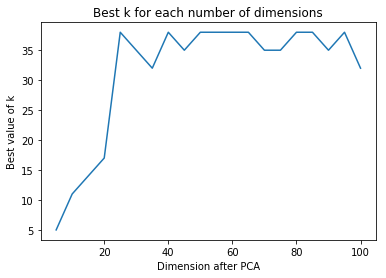

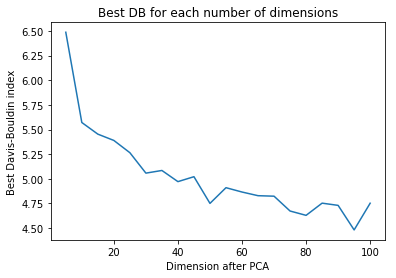

In [10]:
best_ks = []
best_DB = []
test_ns = range(5,101,5)
for ncomps in test_ns:
    reduced = get_pca(ncomps)

    # apply the KMeans algorithm to the reduced data for different values of K
    K = range(2,40,3)
    DB = np.zeros_like(K).astype(float)
    for i, k in enumerate(K):
        kmeans = KMeans(n_clusters = k, random_state=73).fit(reduced)
        with np.errstate(divide='ignore'):
            DB[i] = davies_bouldin_score(mat, kmeans.labels_)
    best_ks.append(K[np.argmin(DB)])
    best_DB.append(np.min(DB))
    # use PCA to reduce the dimension
    reduced = get_pca(ncomps)

plt.plot(test_ns, best_ks)
plt.title("Best k for each number of dimensions")
plt.xlabel("Dimension after PCA")
plt.ylabel("Best value of k")
plt.show()
plt.plot(test_ns, best_DB)
plt.title("Best DB for each number of dimensions")
plt.xlabel("Dimension after PCA")
plt.ylabel("Best Davis-Bouldin index")
plt.show()

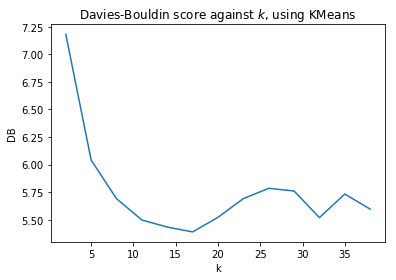

[143, 165, 80, 126, 147, 111, 183, 176, 100, 166, 156, 71, 123, 100, 151, 805, 232]
We have 3049 words, of which 803 are unique
1612 - So we now find out that it was indeed the unverified and Fake Dirty Dossier, that was paid for by Crooked Hillary Clinton and the DNC, that was knowingly &amp; falsely submitted to FISA and which was responsible for starting the totally conflicted and discredited Mueller Witch Hunt!
1183 - How the hell is Bruce Ohr still employed at the Justice Department? Disgraceful!  Witch Hunt!
1337 - “The FBI received documents from Bruce Ohr (of the Justice Department &amp; whose wife Nelly worked for Fusion GPS).” Disgraced and fired FBI Agent Peter Strzok. This is too crazy to be believed! The Rigged Witch Hunt has zero credibility.
1609 - .....”Carter Page wasn’t a spy, wasn’t an agent of the Russians - he would have cooperated with the FBI. It was a fraud and a hoax designed to target Trump.” Tom Fitton @JudicialWatch A disgrace to America. They should drop th

1155 - “President Donald J. Trump is Strengthening Retirement Security for American Workers” https://t.co/cKeATuKXDe
----------------------------------------
We have 2946 words, of which 1112 are unique
2777 - My daughter, Ivanka, just arrived in South Korea. We cannot have a better, or smarter, person representing our country.
471 - Republicans have created the best economy in the HISTORY of our Country – and the hottest jobs market on planet earth. The Democrat Agenda is a Socialist Nightmare. The Republican Agenda is the AMERICAN DREAM! https://t.co/0pWiwCHGbh https://t.co/JfdM1p5xxY
2648 - Larry Kudlow will be my Chief Economic Advisor as Director of the National Economic Council. Our Country will have many years of Great Economic &amp; Financial Success, with low taxes, unparalleled innovation, fair trade and an ever expanding labor force leading the way! #MAGA
835 - Wow, such enthusiasm and energy for Judge Brett Kavanaugh. Look at the Energy, look at the Polls. Something very bi

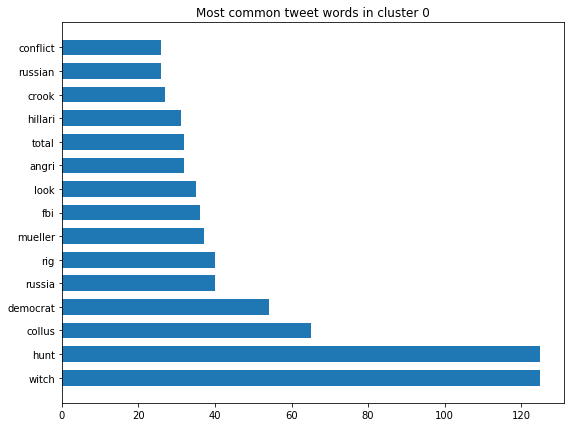

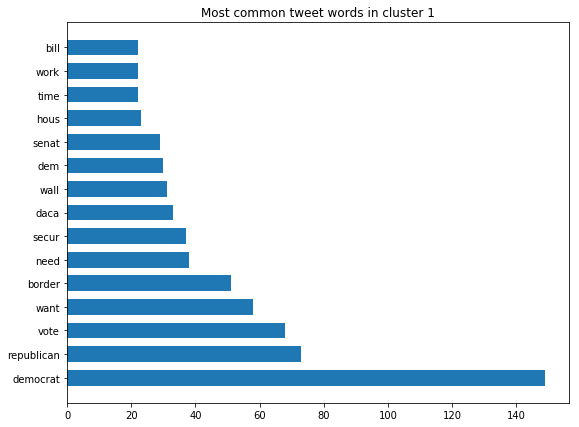

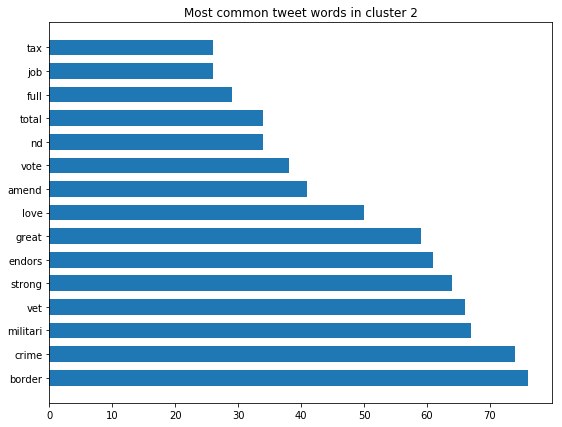

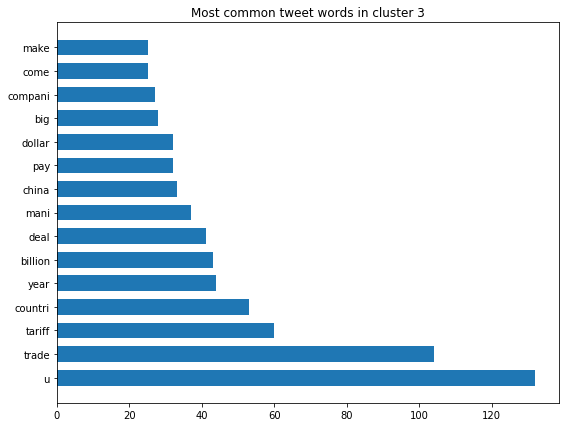

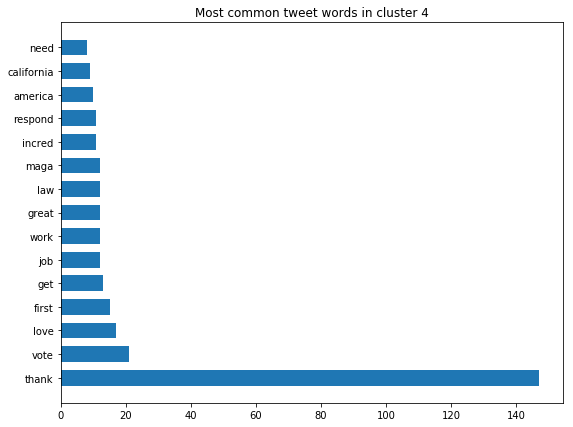

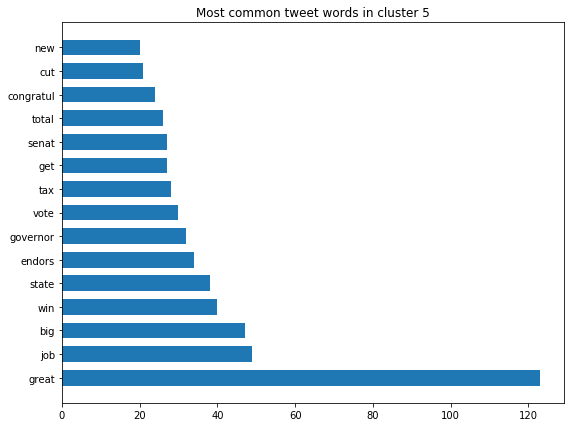

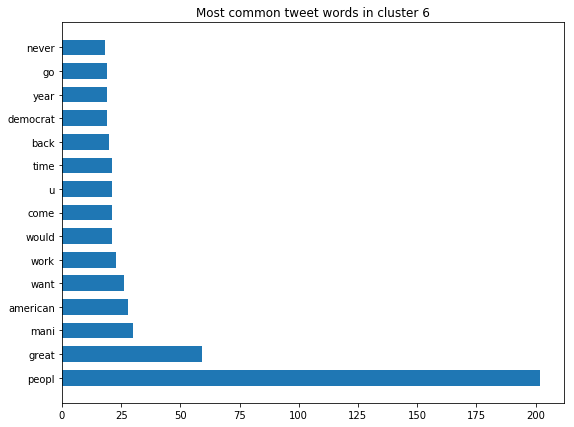

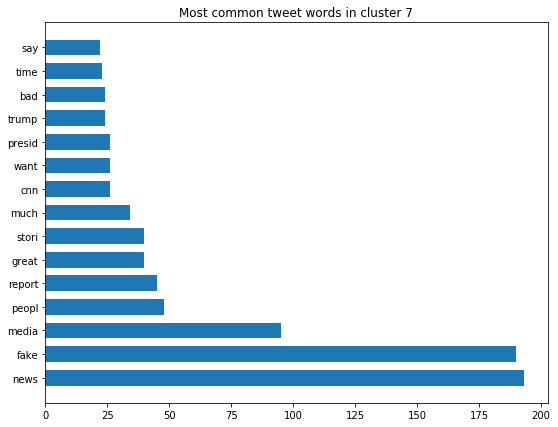

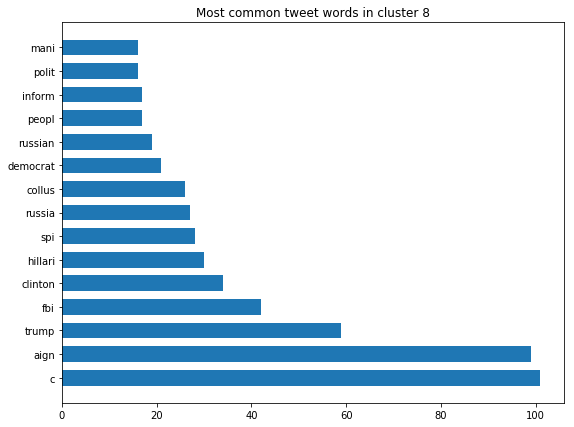

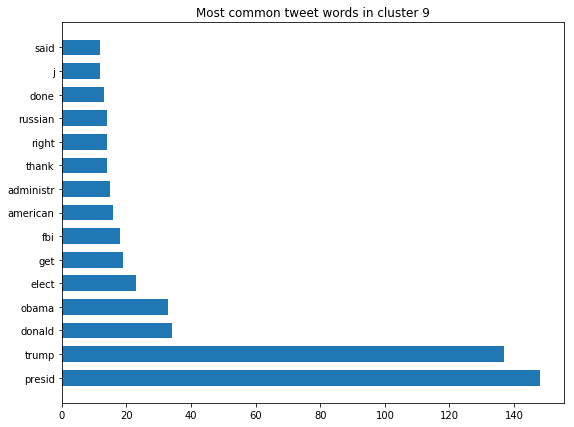

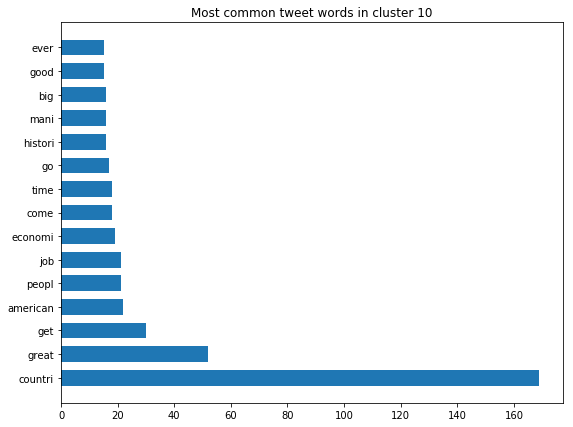

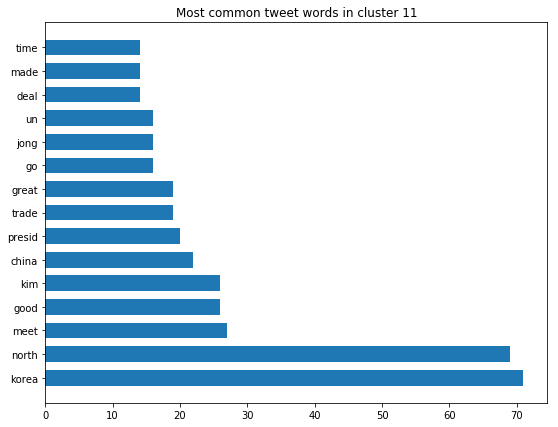

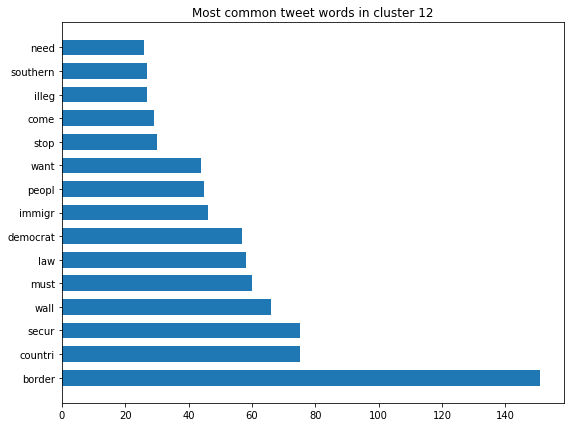

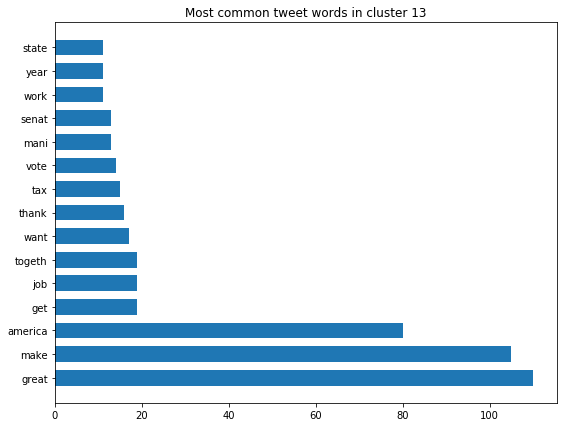

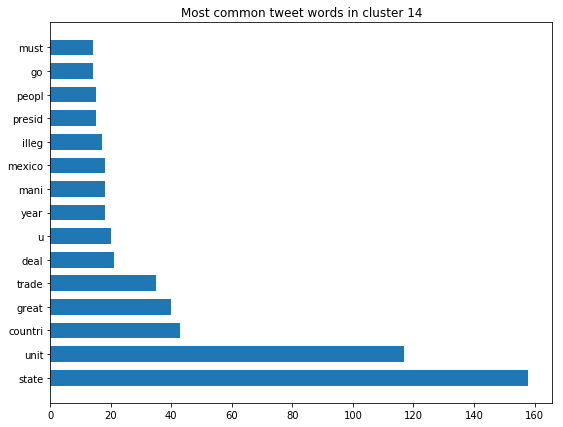

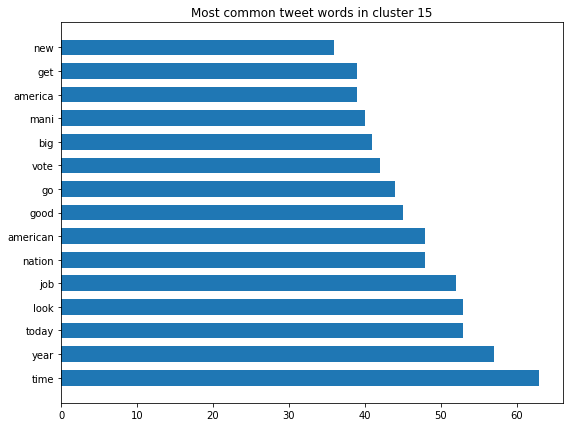

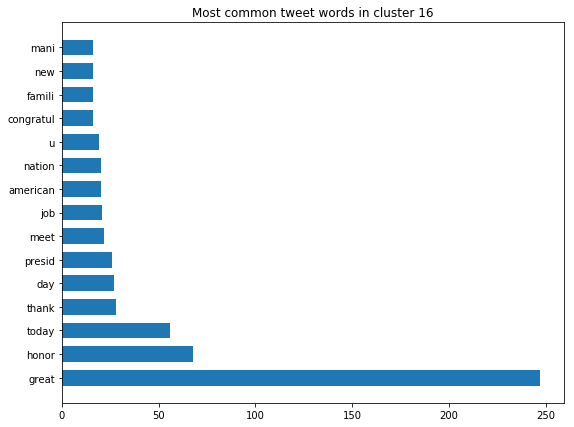

In [11]:
reduced = get_pca(20)

# apply the KMeans algorithm to the reduced data for different values of K
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
for i, k in enumerate(K):
    kmeans = KMeans(n_clusters = k, random_state=73).fit(reduced)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, kmeans.labels_)
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'Davies-Bouldin score against $k$, using KMeans')
plt.show()


kmeans = KMeans(n_clusters = k_opt, random_state=73).fit(reduced)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, sk_clusters)))



random.seed(52345234)
# take some random tweets from every cluster
explore_clusters(sk_clusters)

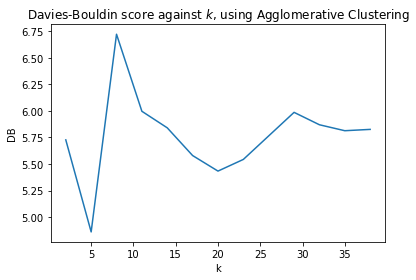

[2435, 99, 191, 177, 133]
We have 39843 words, of which 4502 are unique
1535 - ...and the Amazon Washington Post do nothing but write bad stories even on very positive achievements - and they will never change!
2122 - Very importantly, @RepDanDonovan will win for the Republicans in November...and his opponent will not. Remember Alabama. We can’t take any chances on losing to a Nancy Pelosi controlled Democrat!
1657 - While the NATO meeting in Brussels was an acknowledged triumph, with billions of dollars more being put up by member countries at a faster pace, the meeting with Russia may prove to be, in the long run, an even greater success. Many positive things will come out of that meeting..
2594 - THE SECOND AMENDMENT WILL NEVER BE REPEALED! As much as Democrats would like to see this happen, and despite the words yesterday of former Supreme Court Justice Stevens, NO WAY. We need more Republicans in 2018 and must ALWAYS hold the Supreme Court!
546 - Stock Market up more than 400 poin

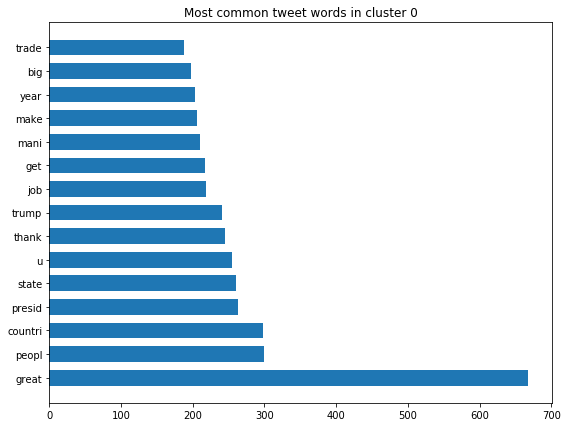

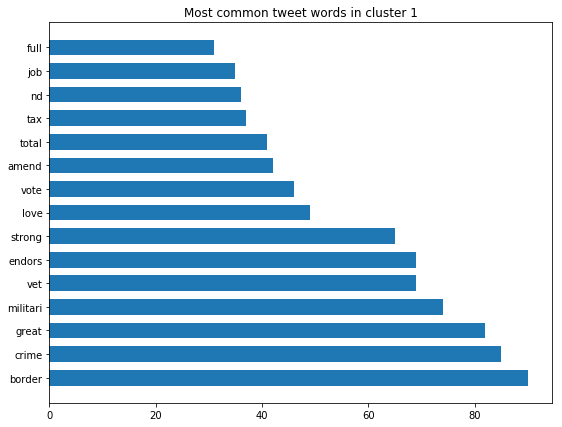

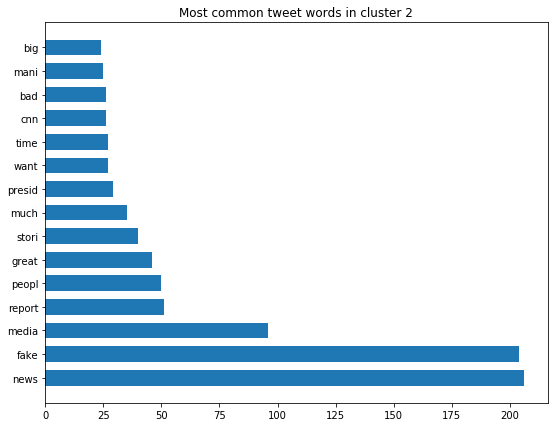

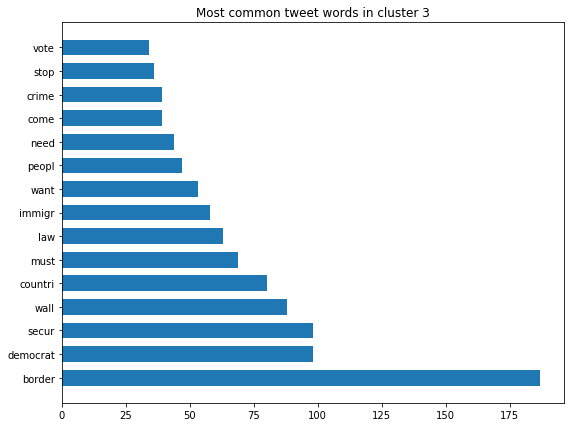

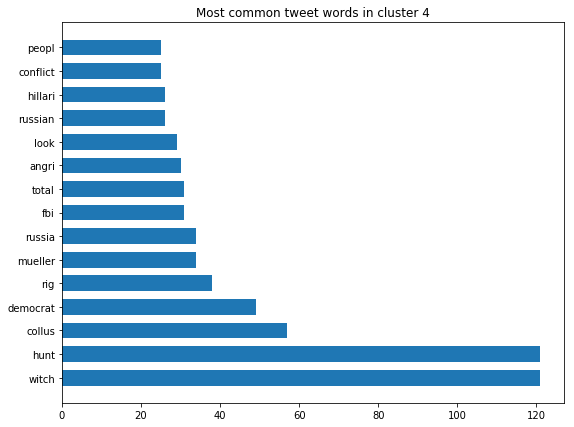

In [6]:
reduced = get_pca(20)
# apply 

# apply agglomerative clustering to the reduced data for different values of k (n_clusters)
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
i = 0
for k in K:
    kmeans = AgglomerativeClustering(n_clusters = k).fit(reduced)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, kmeans.labels_)
    i += 1
k_opt = K[np.argmin(DB)]
plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(f'Davies-Bouldin score against $k$, using Agglomerative Clustering')
plt.show()

agg = AgglomerativeClustering(n_clusters=k_opt).fit(reduced)
agg_clusters = [[] for i in range(max(agg.labels_+1))]
for idx, lbl in enumerate(agg.labels_):
    agg_clusters[lbl].append(idx)

print(list(map(len, agg_clusters)))

random.seed(162323)
# take some random tweets from every cluster
explore_clusters(agg_clusters)

[99, 160, 163, 177, 193, 191, 749, 85, 156, 133, 51, 110, 155, 100, 109, 120, 64, 90, 47, 83]
We have 2320 words, of which 515 are unique
1086 - Getting ready to go on stage for Matt Rosendale, who will be a great Senator. Jon Tester has let the people of Montana down &amp; does not deserve another six years. Matt is strong on Crime, the Borders, &amp; will save your Second Amendment from the onslaught. Loves our Military &amp; Vets!
1436 - Ohio, vote today for Troy Balderson for Congress. His opponent, controlled by Nancy Pelosi, is weak on Crime, the Border, Military, Vets, your 2nd Amendment - and will end your Tax Cuts. Troy will be a great Congressman. #MAGA
1157 - I will be doing a major rally for Senator Ted Cruz in October. I’m picking the biggest stadium in Texas we can find. As you know, Ted has my complete and total Endorsement. His opponent is a disaster for Texas - weak on Second Amendment, Crime, Borders, Military, and Vets!
1557 - ...John is strong on crime and borders, 

1762 - Heading to West Virginia to be with my friend, @WVGovernor Jim Justice, at his beautiful Greenbrier Resort. He works hard, does a great job, and raises lots of money for charities!
2739 - Unemployment filings are at their lowest level in over 48 years. Great news for workers and JOBS, JOBS, JOBS! #MAGA https://t.co/SzHTarzfrW
1329 - In speaking with some of the world’s top business leaders I asked what it is that would make business (jobs) even better in the U.S. “Stop quarterly reporting &amp; go to a six month system,” said one. That would allow greater flexibility &amp; save money. I have asked the SEC to study!
178 - Great job by Michael Anton on @foxandfriends. A true National Security expert!
1604 - Robert will do a great job for our Vets. We also recently won Choice! https://t.co/hE0GDuCBET
----------------------------------------
We have 1856 words, of which 846 are unique
101 - “I’m proud of the President today to hear that he is declaring victory in Syria.” Senator Ran

We have 944 words, of which 406 are unique
530 - Thank you to Rick Breckenridge and congratulations to Matt Rosendale (@MattForMontana). This is very big - see you in Montana on Saturday! Tickets: https://t.co/zX9sj0qUzN https://t.co/UWuHHs6Y0u
1070 - The Dems have tried every trick in the playbook-call me everything under the sun. But if I’m all of those terrible things, how come I beat them so badly, 306-223? Maybe they’re just not very good! The fact is they are going CRAZY only because they know they can’t beat me in 2020!
1940 - Holding back the “war games” during the negotiations was my request because they are VERY EXPENSIVE and set a bad light during a good faith negotiation. Also, quite provocative. Can start up immediately if talks break down, which I hope will not happen!
2695 - Kim Jong Un talked about denuclearization with the South Korean Representatives, not just a freeze. Also, no missile testing by North Korea during this period of time. Great progress being made but s

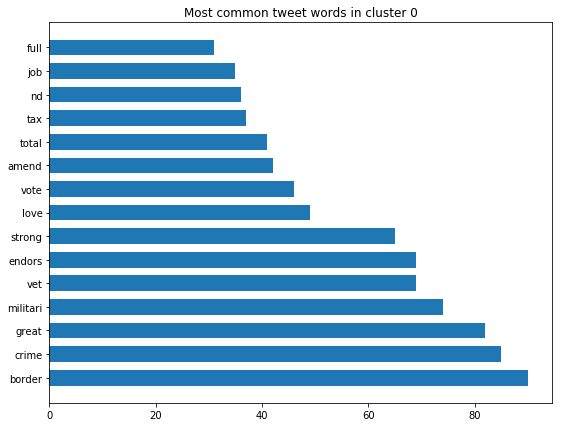

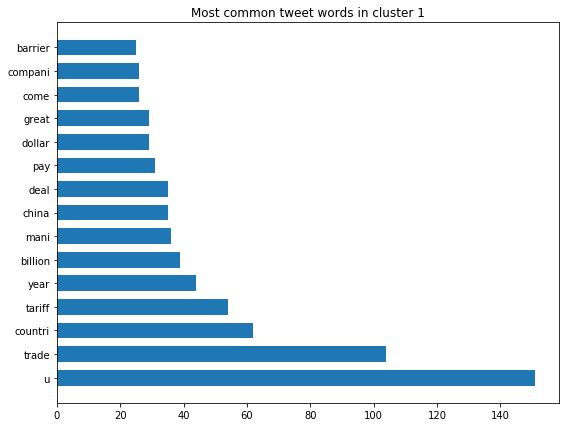

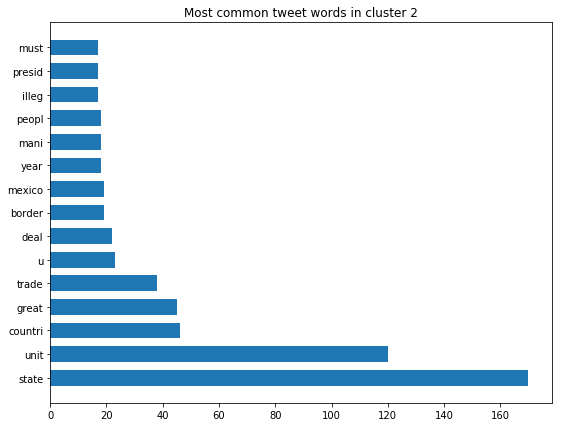

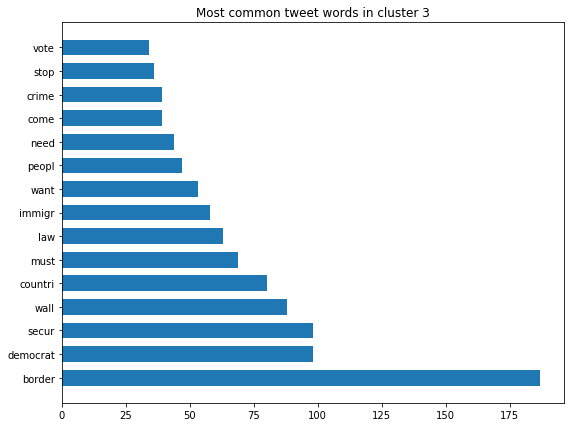

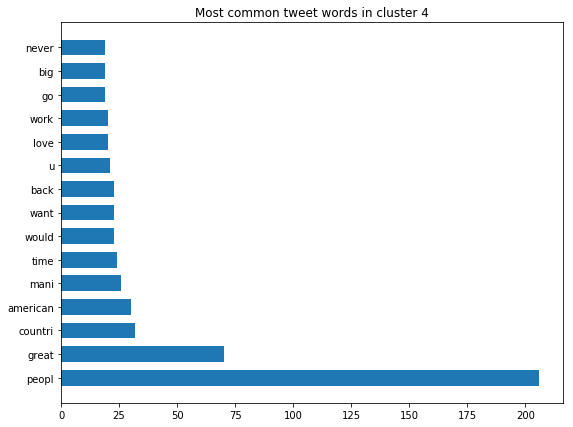

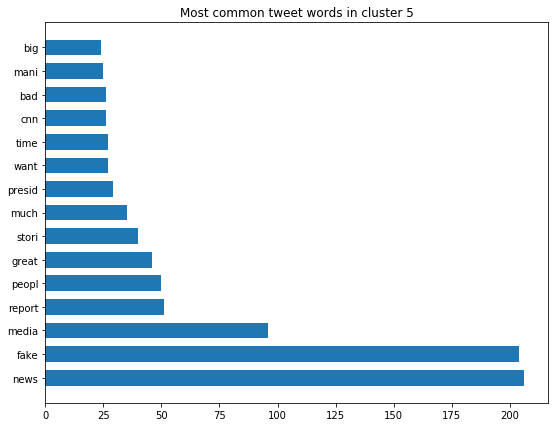

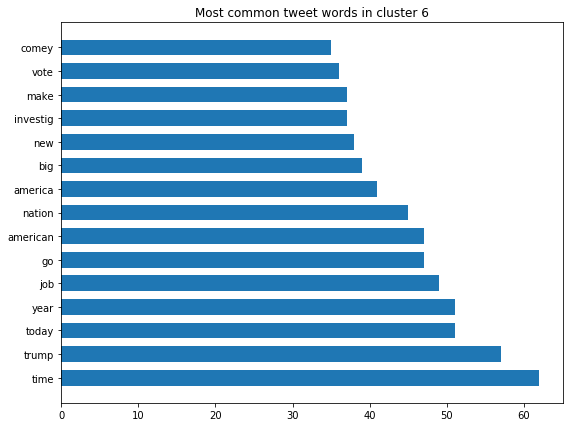

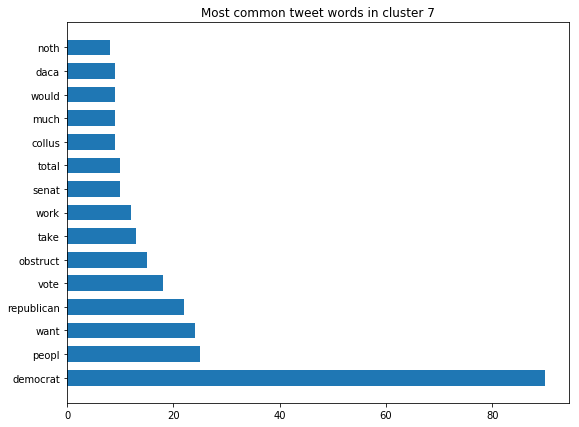

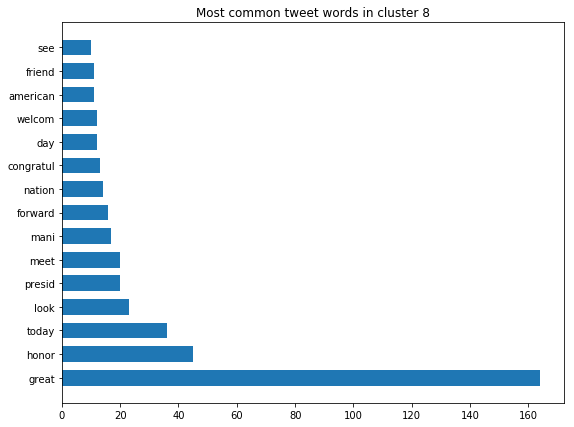

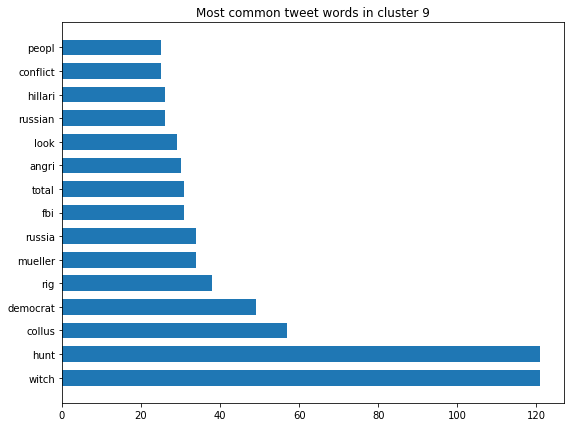

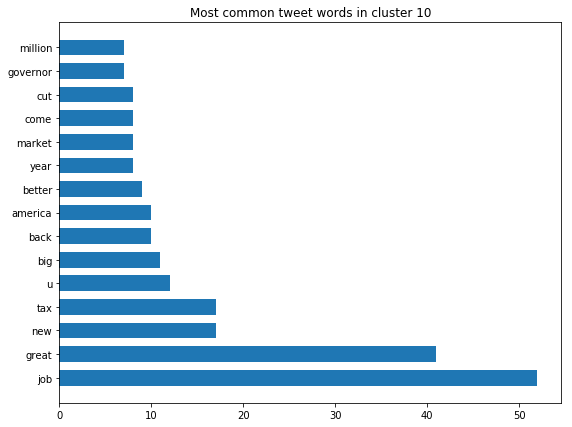

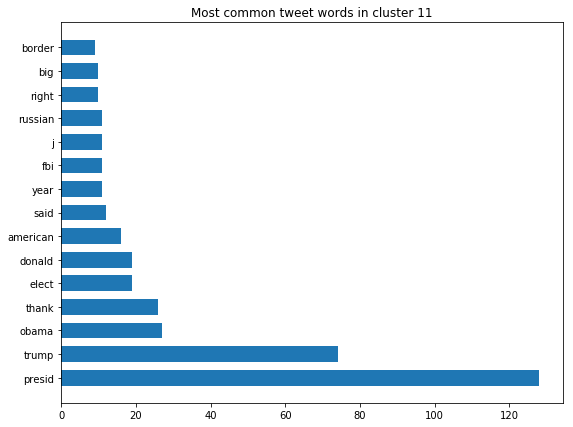

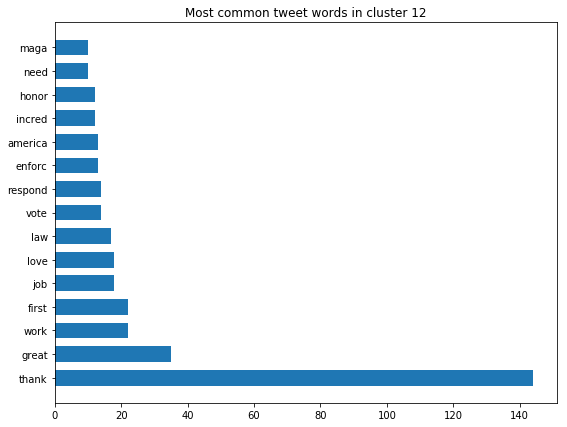

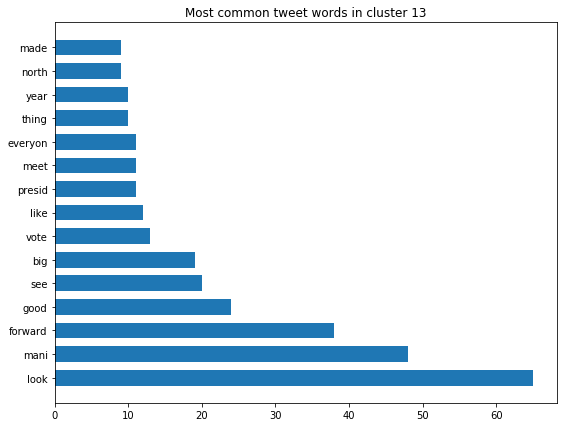

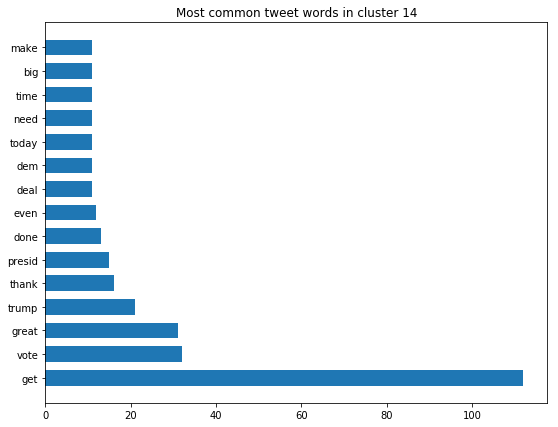

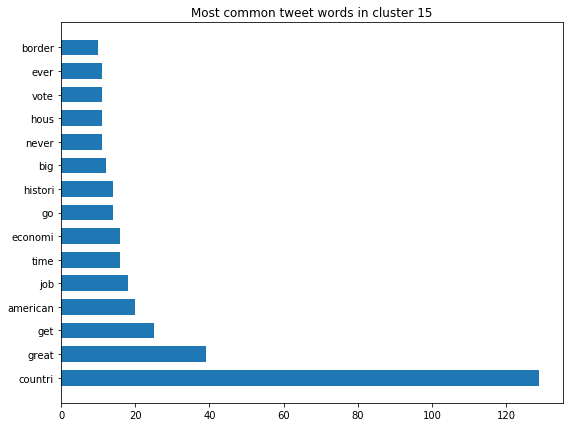

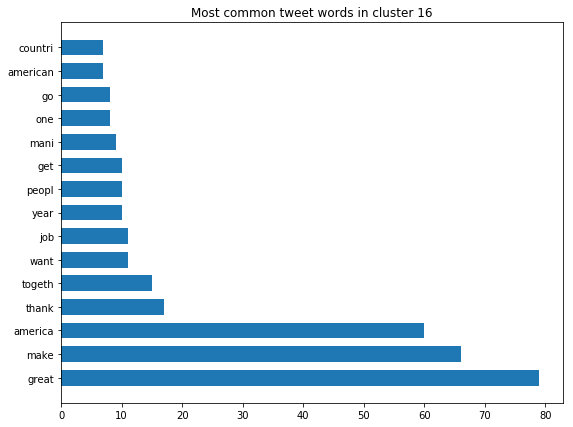

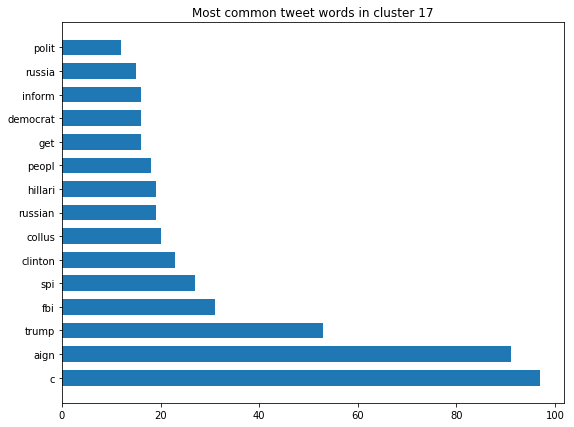

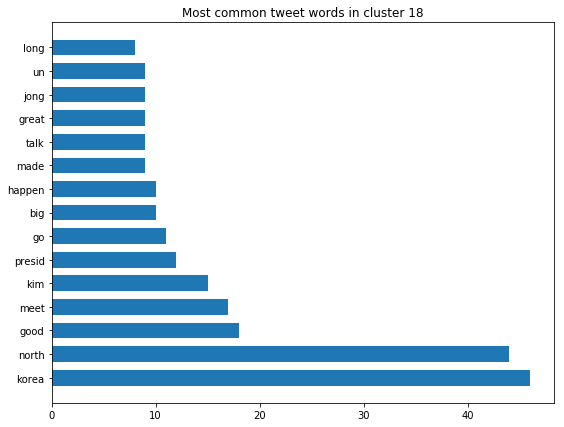

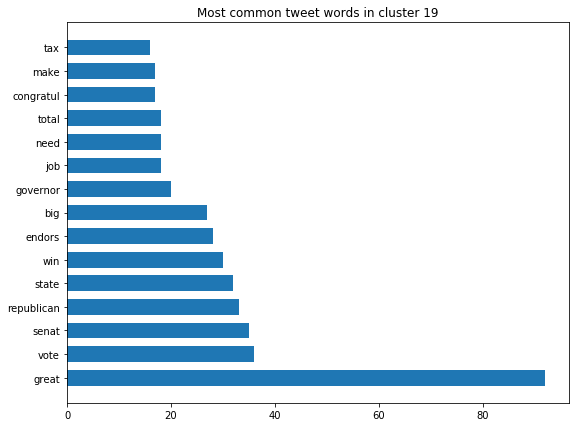

In [7]:
# The first cluster is not good, so try with more clusters
reduced = get_pca(20)
agg = AgglomerativeClustering(n_clusters=20).fit(reduced)
agg_clusters = [[] for i in range(max(agg.labels_+1))]
for idx, lbl in enumerate(agg.labels_):
    agg_clusters[lbl].append(idx)

print(list(map(len, agg_clusters)))

random.seed(162323)
# take some random tweets from every cluster
explore_clusters(agg_clusters)

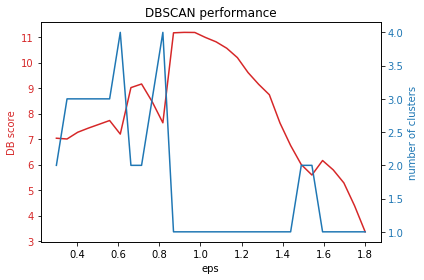

In [17]:
# apply the DBSCAN algorithm to the data for different values of K
# FIX THE ARGUMENT MIN_SAMPLES
reduced = get_pca(20)
Eps = np.linspace(.3,1.8,30)
DB = np.zeros_like(Eps).astype(float)
sizes = []
for i, eps in enumerate(Eps):
    dbscan = DBSCAN(eps = eps, min_samples=30).fit(reduced)
    dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
    for idx, lbl in enumerate(dbscan.labels_):
        dbscan_clusters[lbl].append(idx)
    sizes.append(len(dbscan_clusters))
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, dbscan.labels_)
        
## Plot results of DBSCAN for different valus of eps
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('eps')
ax1.set_ylabel('DB score', color=color)
ax1.plot(Eps, DB, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('number of clusters', color=color)  # we already handled the x-label with ax1
ax2.plot(Eps, sizes, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(f'DBSCAN performance')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

[2902, 133]
We have 50002 words, of which 4765 are unique
1202 - “Consumer confidence pops in August to highest level since October 2000” https://t.co/1Gg5IOtbNa
2923 - Will be interviewed on  @SquawkCNBC by @JoeSquawk coming up at 6:00amE from Davos, Switzerland. Enjoy! #WEF18 https://t.co/7egYlxnFBd
688 - Will be landing soon. Looking forward to seeing our next Senator from Montana, Matt Rosendale. He will represent our Country well, far better than Jon Tester who will vote with Cryin’ Chuck Schumer and Nancy Pelosi - never with us!
2030 - It’s my great honor to welcome Prime Minister @AbeShinzo back to the @WhiteHouse!???????? https://t.co/6yCxud2jAN
1495 - It was my great honor to be joined by leading pastors and faith leaders from across our Nation today at the @WhiteHouse! https://t.co/6sS1zGA1p7
----------------------------------------
We have 3303 words, of which 847 are unique
2444 - .@MarshaBlackburn is a wonderful woman who has always been there when we have needed her. Grea

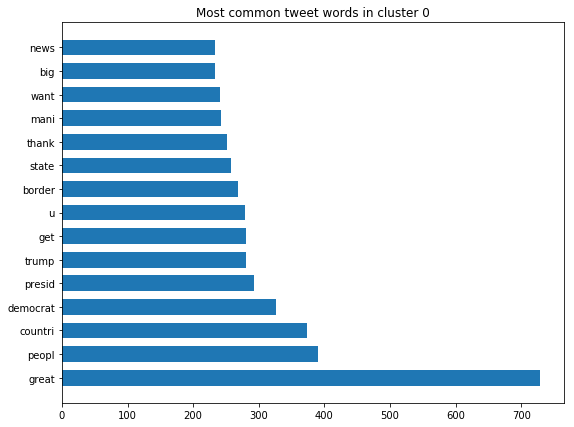

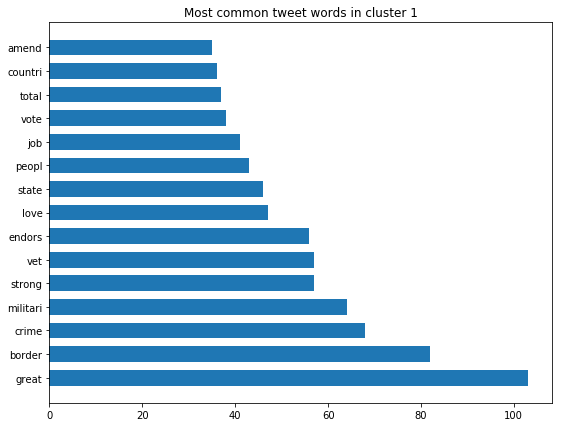

In [18]:
reduced = get_pca(20)
# apply the DBSCAN algorithm to the reduced data
dbscan = DBSCAN(eps=1.5, min_samples=30).fit(reduced)
dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
for idx, lbl in enumerate(dbscan.labels_):
    dbscan_clusters[lbl].append(idx)
    
print(list(map(len, dbscan_clusters)))

random.seed(3452314)
# take some random tweets from every cluster
explore_clusters(dbscan_clusters)

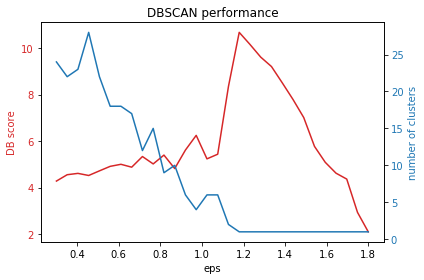

In [19]:
# apply the DBSCAN algorithm to the data for different values of K
# FIX THE ARGUMENT MIN_SAMPLES
reduced = get_pca(20)
Eps = np.linspace(.3,1.8,30)
DB = np.zeros_like(Eps).astype(float)
sizes = []
for i, eps in enumerate(Eps):
    dbscan = DBSCAN(eps = eps).fit(reduced)
    dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
    for idx, lbl in enumerate(dbscan.labels_):
        dbscan_clusters[lbl].append(idx)
    sizes.append(len(dbscan_clusters))
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, dbscan.labels_)
        
## Plot results of DBSCAN for different valus of eps
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('eps')
ax1.set_ylabel('DB score', color=color)
ax1.plot(Eps, DB, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('number of clusters', color=color)  # we already handled the x-label with ax1
ax2.plot(Eps, sizes, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(f'DBSCAN performance')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

[1327, 233, 25, 57, 7, 14, 6, 17, 5, 6, 5, 1333]
We have 17528 words, of which 3307 are unique
1227 - “The FBI only looked at 3000 of 675,000 Crooked Hillary Clinton Emails.” They purposely didn’t look at the disasters. This news is just out. @FoxNews
793 - .@FLGovScott has been relentless in securing the funding to fix the algae problem from Lake Okeechobee - we will solve this! Congress must follow through on the Government’s plan on the Everglades Reservoir. Bill Nelson has been no help!
2202 - @foxandfriends  “New Bombshell in the Obama Spying Scandal. Did other Agencies SPY on Trump Campaign?” Even Clapper, worlds dumbest former Intelligence Head, who has the problem of lying a lot, used the word SPY when describing the illegal activities!
1567 - PROMISES KEPT! https://t.co/vR2R5WXPVD
2210 - The Wall Street Journal asks, “WHERE IN THE WORLD WAS BARACK OBAMA?”  A very good question!
----------------------------------------
We have 3008 words, of which 1202 are unique
1879 - Republi

1157 - I will be doing a major rally for Senator Ted Cruz in October. I’m picking the biggest stadium in Texas we can find. As you know, Ted has my complete and total Endorsement. His opponent is a disaster for Texas - weak on Second Amendment, Crime, Borders, Military, and Vets!
1186 - Martha McSally is an extraordinary woman. She was a very talented fighter jet pilot and is now a highly respected member of Congress. She is Strong on Crime, the Border and our  under siege 2nd Amendment. Loves our Military and our Vets. Has my total and complete Endorsement!
1557 - ...John is strong on crime and borders, loves our Military, our Vets and our Second Amendment. He will be a star. He has my full and total Endorsement!
1527 - .@Troy_Balderson of Ohio is running for Congress - so important to the Republican Party. Troy is strong on crime and Borders, loves our Military, our Vets and our Second Amendment. Troy will strongly protect...
511 - Scott Perry of Pennsylvania is fantastic. He is stro

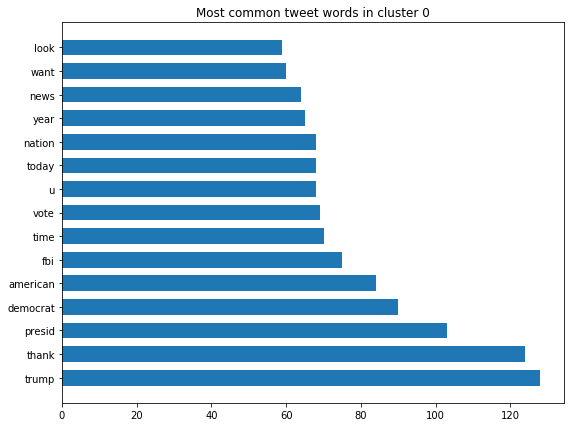

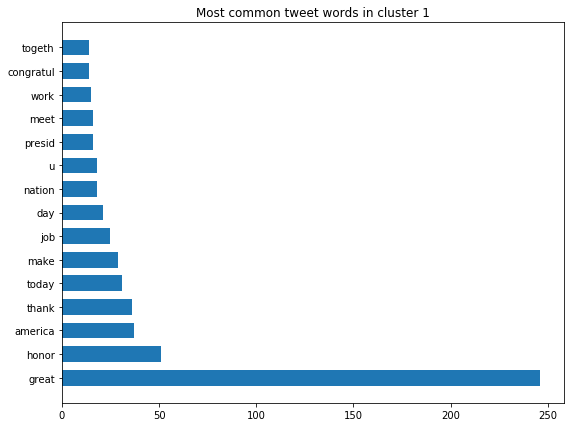

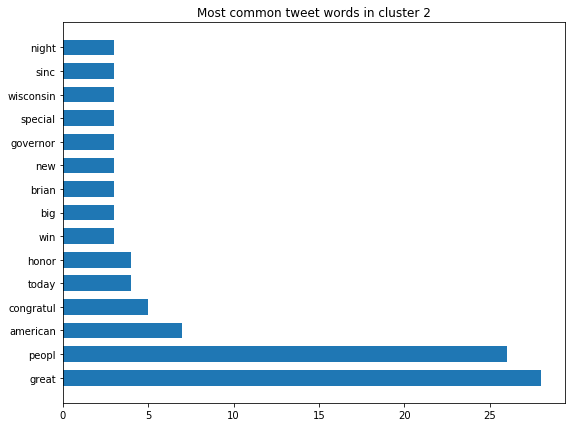

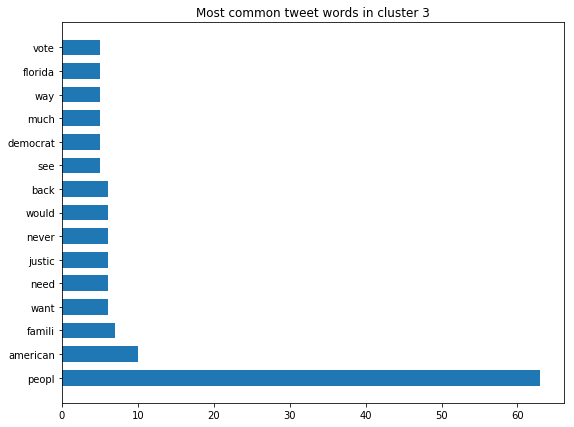

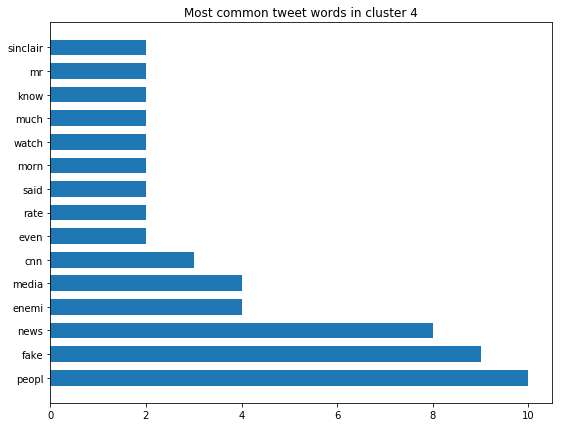

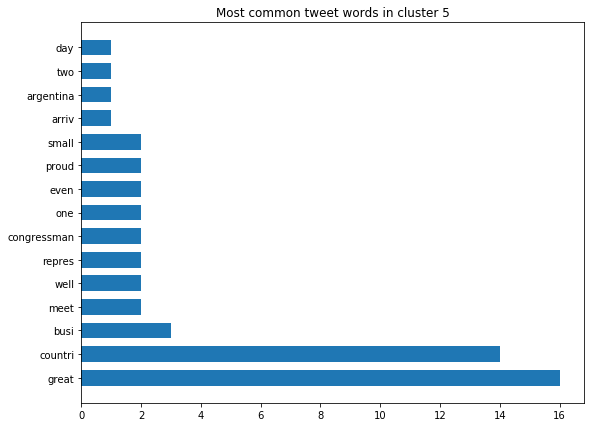

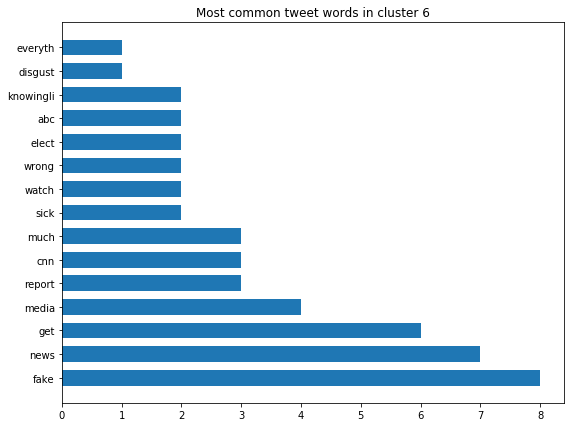

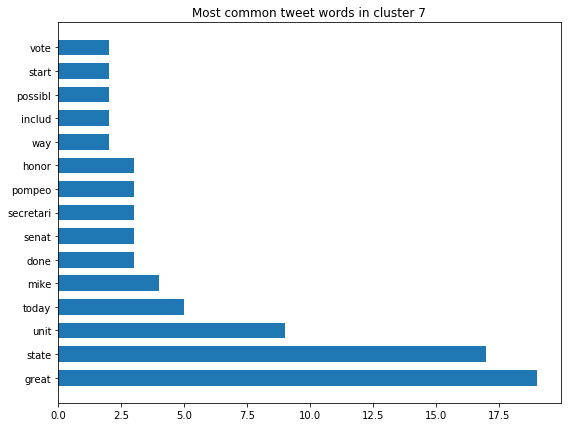

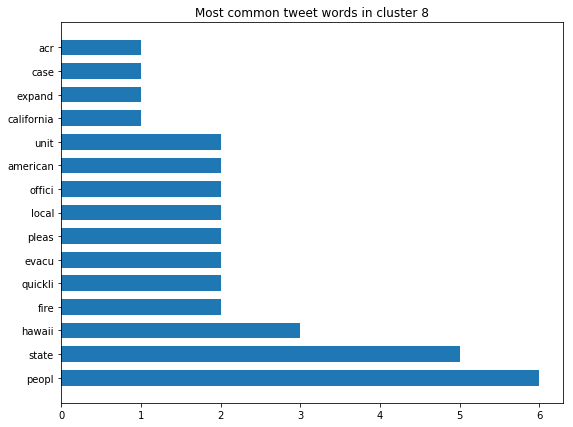

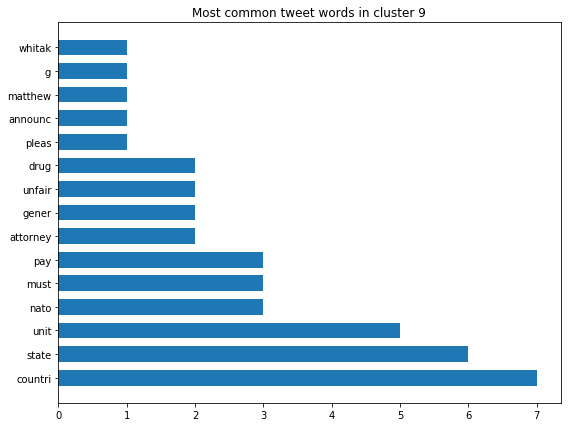

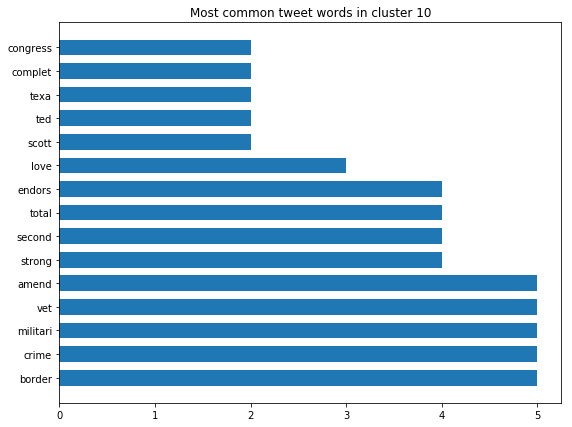

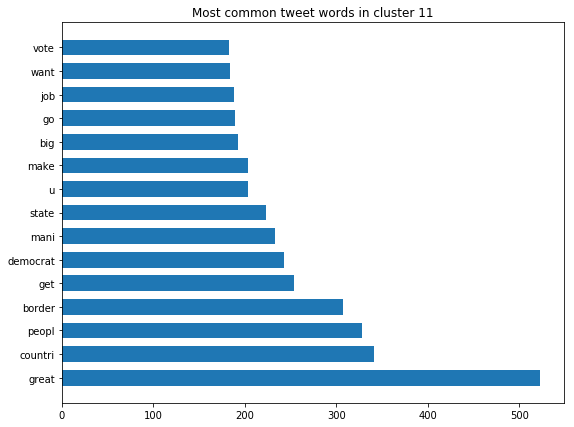

In [20]:
reduced = get_pca(20)
# apply the DBSCAN algorithm to the reduced data
dbscan = DBSCAN(eps=0.8).fit(reduced)
dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
for idx, lbl in enumerate(dbscan.labels_):
    dbscan_clusters[lbl].append(idx)
    
print(list(map(len, dbscan_clusters)))

random.seed(3452314)
# take some random tweets from every cluster
explore_clusters(dbscan_clusters)